In [ ]:
#Run for 1 minute and allow crash, then select 'Get More RAM' in pop-up dialog box
a = []
while(1):
    a.append('1')

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#@title Image configurations L x W x Chan
nrows = 400 #Length of image
ncolumns = 100 # Height of image
channels = 1 # Gray = 1, Colour = 3
batch_size = 32

In [ ]:
from PIL import Image # used for loading images
import os # used for navigating to image path
import imageio # used for writing images
import keras
from keras import layers
from keras import models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import tensorflow as tf
import cv2
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from functools import partial
from itertools import repeat
from multiprocessing import Pool, freeze_support
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, ZeroPadding2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from os import listdir
from os.path import isfile, join
import multiprocessing as mp
from queue import Empty
import math
cv2.resize(np.zeros((1, 1), np.uint8), (1, 1))
print(tf.__version__)


Using TensorFlow backend.


2.2.0-rc3


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpus))

GPUs Available:  1


In [ ]:
#Load list of images
def load_image_list(savedir):
  images = []
  images = [f for f in listdir(savedir) if isfile(join(savedir, f))]
  print('Number of images in dir: ' + str(len(images)))
  return images

In [ ]:
savedir = "/content/drive/My Drive/BEAT_PD/Data/CIS-PD/training_data/HAR/TS_Plots/1006/"
images = load_image_list(savedir)

Number of images in dir: 10803


In [ ]:
# Read all labels from User's filenames
def read_labels(list_images):
  X = []
  y_on_off = []
  y_dys = []
  y_trem = []
  measurement_id =[]
  frame = []
  full_label = []
  for image in tqdm(list_images):
    measurement_id.append(image.split('_')[0])
    y_on_off.append(image.split('_')[3])
    y_dys.append(image.split('_')[5])
    y_trem.append(image.split('_')[7])
    frame.append(image.split('_')[8])
    full_label.append(image)
  return y_on_off, y_dys, y_trem, measurement_id, frame, full_label
  
y_on_off, y_dys, y_trem, measurement_id, frame, full_label = read_labels(images)

100%|██████████| 10803/10803 [00:00<00:00, 257009.69it/s]


In [ ]:
# Loop to iterate through measurements, count its target class and split into train and test depending on the ration
def CountFrequency(my_list): 
  # Creating an empty dictionary  
  freq = {} 
  for item in my_list: 
      if (item in freq): 
          freq[item] += 1
      else: 
          freq[item] = 1
  label_count = {}
  for key, value in freq.items(): 
    label_count[key] = value
    print ("% d : % d"%(int(float(key)), int(value))) 
  return label_count

def get_meas_list(dfcur, unique_meas, target, split_ratio = 0.7):
  curr_label_count = {}
  train_meas = []
  test_meas = []
  for meas in unique_meas:
    curr_label = dfcur.loc[dfcur['measurement_id']==str(meas)][target].values[0]
    curr_label_count[str(curr_label)] = curr_label_count.get(str(curr_label), 0) + 1
    if curr_label_count[str(curr_label)] <= int(round(label_count[curr_label] * split_ratio)):
      train_meas.append(meas)
    else:
      test_meas.append(meas)
  return train_meas, test_meas

In [ ]:
#Split data for measurement_id
def split_data(label, y, meas_id):
  label_train, label_test, y_train, y_test = train_test_split(label, y, test_size = 0.2, random_state=2, stratify = meas_id)
  while len(set(y_train)) != len(set(y_test)):
    label_train, label_test, y_train, y_test = train_test_split(label, y, test_size = 0.2, random_state=2, stratify = meas_id)
    
  return label_train, label_test, y_train, y_test

#Load and resize image
def img_resize(image, savedir):
  image =cv2.resize(cv2.imread((savedir + image), cv2.IMREAD_GRAYSCALE), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC)
  return image

#Load labels and images
def read_and_process_images(list_images, savedir):
  X = []
  y_on_off = []
  y_dys = []
  y_trem = []
  measurement_id =[]
  frame = []
  for image in tqdm(list_images):
    try:
      X.append(img_resize(image, savedir))
    except:
      print('Cant load file' + str(image))
      continue
    measurement_id.append(image.split('_')[0])
    y_on_off.append(image.split('_')[3])
    y_dys.append(image.split('_')[5])
    y_trem.append(image.split('_')[7])
    frame.append(image.split('_')[8])

  return X, y_on_off, y_trem, y_dys, measurement_id, frame

#Setup train and test variables
def setup_var(X_train, X_test, y_train, y_test):
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  classes = list(set(y_train))
  classes_test = list(set(y_test))
  print('Number of y classes:\n ' + str(classes))
  y_bi_train = label_binarize(y_train, classes = classes)
  y_bi_test = label_binarize(y_test, classes = classes_test)

  X_train = X_train.reshape(len(X_train),ncolumns,nrows,1)
  X_train = X_train.astype('float32')
  X_test = X_test.reshape(len(X_test),ncolumns,nrows,1)
  X_test = X_test.astype('float32')
  #y_train = y_bi_train
  #y_test = y_bi_test
  return X_train, X_test, y_train, y_test, y_bi_train, y_bi_test

  #Build CNN model
def build_model(nrows, ncolumns, channels, y_test, y_bi_test): #https://kauri.io/multiclass-classification-example-with-convolution/145b4c03a55146cba2051f04e7f499e9/a
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (nrows, ncolumns, channels)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense((y_bi_test.shape[1]), activation = "softmax"))
    
    model.compile(
        optimizer='adam',
        loss=['sparse_categorical_crossentropy'],
        metrics=['accuracy']
    )
    return model

def build_model_VGG16(nrows, ncolumns, channels, y_test, y_bi_test, weights_path): #https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (nrows, ncolumns, channels)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu',strides=(2, 2)))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(MaxPool2D(pool_size=(2,2)))

    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense((y_bi_test.shape[1]), activation='softmax'))

    if os.path.isdir(weights_path):
        model.load_weights(weights_path)

    model.compile(
        optimizer='adam',
        loss=['sparse_categorical_crossentropy'],
        metrics=['accuracy']
    )
    return model

#Train CNN
def train_model(X_train, X_test, y_train, y_test, batch_size, nrows, ncolumns, channels, y_bi_test, Model=None, weights_path=None):
  ntrain = len(X_train)
  nval = len(X_test)
  print(nval)
  tensorboard = TensorBoard(log_dir=f"logs/{time.time()}", histogram_freq=1)
  if Model == 'VGG16':
    print('VGG16 model')
    model = build_model_VGG16(nrows, ncolumns, channels, y_test, y_bi_test, weights_path)
  else:
    model = build_model(nrows, ncolumns, channels, y_test, y_bi_test)
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)
  val_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow(X_train, y_train.astype('float32'), batch_size=batch_size)
  val_generator = val_datagen.flow(X_test, y_test.astype('float32'), batch_size= batch_size)

  # https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9
  history = model.fit_generator(train_generator, 
                                steps_per_epoch = ntrain//batch_size,
                                epochs = 64, validation_data = val_generator,
                                validation_steps = nval//batch_size)
  return history

In [ ]:
#Split the image list measurements by test and train
user_df = pd.DataFrame(list(zip(list(np.float_(y_on_off)), list(np.float_(y_dys)), list(np.float_(y_trem)), measurement_id)),
              columns=['y_on_off', 'y_dys', 'y_trem', 'measurement_id'])

target = 'y_trem'


unique_df = pd.DataFrame(user_df.groupby(['measurement_id']).median())
label_count = CountFrequency(unique_df[target])
unique_meas = set(user_df.measurement_id)
unique_df['measurement_id'] = unique_df.index
train_meas, test_meas = get_meas_list(unique_df, unique_meas, target)

#Make a dataframe for splitting labels and measurements
user_labels = pd.DataFrame(list(zip(y_on_off, y_dys, y_trem, measurement_id, frame, full_label)),
              columns=['y_on_off', 'y_dys', 'y_trem', 'measurement_id', 'frame', 'full_label'])
train_df = user_labels[user_labels['measurement_id'].isin(train_meas)]
test_df = user_labels[user_labels['measurement_id'].isin(test_meas)]

print('Are measurements shared across the split?')
bool(set(test_df.measurement_id)&set(train_df.measurement_id))

 1 :  18
 0 :  12
 2 :  7
Are measurements shared across the split?


False

In [ ]:
X_trem, y_1, y_trem, y_2, measurement_id, frame = read_and_process_images(train_df.full_label, savedir)
X_trem_test, y_1_test, y_trem_test, y_2_test, measurement_id_test, frame_test = read_and_process_images(test_df.full_label, savedir)

100%|██████████| 3053/3053 [12:17<00:00,  4.14it/s]


In [ ]:
X_train, X_test, y_train, y_test, y_bi_train, y_bi_test = setup_var(X_trem, X_trem_test, y_trem, y_trem_test)

Number of y classes:
 ['1.0', '2.0', '0.0']


3053
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/64
242/242 [==============================] - 79s 328ms/step - loss: 1.0877 - accuracy: 0.4956 - val_loss: 0.9994 - val_accuracy: 0.4914
Epoch 2/64
242/242 [==============================] - 79s 326ms/step - loss: 1.0329 - accuracy: 0.5040 - val_loss: 0.9986 - val_accuracy: 0.4914
Epoch 3/64
242/242 [==============================] - 79s 326ms/step - loss: 1.0353 - accuracy: 0.5014 - val_loss: 0.9994 - val_accuracy: 0.4918
Epoch 4/64
242/242 [==============================] - 79s 326ms/step - loss: 1.0268 - accuracy: 0.5048 - val_loss: 1.0091 - val_accuracy: 0.4914
Epoch 5/64
242/242 [==============================] - 79s 326ms/step - loss: 1.0285 - accuracy: 0.5032 - val_loss: 0.9949 - val_accuracy: 0.4911
Epoch 6/64
242/242 [==============================] - 79s 325ms/step - loss: 1.0285 - accuracy: 0.5030 - val_loss: 1.0003 - val_accuracy: 0.4914
Epoch 7/64
242/242 [=============================

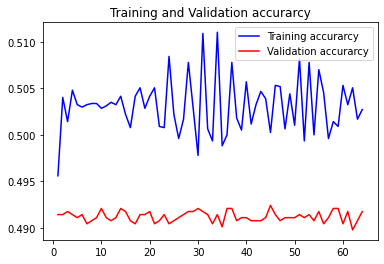

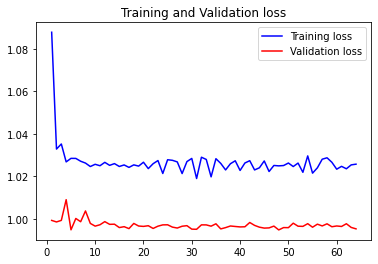

In [ ]:
history = train_model(X_train, X_test, y_train, y_test, batch_size, nrows, ncolumns, channels, y_bi_test)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
history = train_model(X_train, X_test, y_train, y_test, batch_size, nrows, ncolumns, channels, y_bi_test)

#Previous Split Method & Model

In [ ]:
#Make a dataframe for splitting labels and measurements
user_labels = pd.DataFrame(list(zip(y_on_off, y_dys, y_trem, measurement_id, frame, full_label)),
              columns=['y_on_off', 'y_dys', 'y_trem', 'measurement_id', 'frame', 'full_label'])
user_labels

In [ ]:
#Split data for measurement_id
def split_data(label, y, meas_id):
  label_train, label_test, y_train, y_test = train_test_split(label, y, test_size = 0.2, random_state=2, stratify = meas_id)
  while len(set(y_train)) != len(set(y_test)):
    label_train, label_test, y_train, y_test = train_test_split(label, y, test_size = 0.2, random_state=2, stratify = meas_id)
    
  return label_train, label_test, y_train, y_test

#Load and resize image
def img_resize(image, savedir):
  image =cv2.resize(cv2.imread((savedir + image), cv2.IMREAD_GRAYSCALE), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC)
  return image

#Load labels and images
def read_and_process_images(list_images, savedir):
  X = []
  y_on_off = []
  y_dys = []
  y_trem = []
  measurement_id =[]
  frame = []
  for image in tqdm(list_images):
    try:
      X.append(img_resize(image, savedir))
    except:
      print('Cant load file' + str(image))
      continue
    measurement_id.append(image.split('_')[0])
    y_on_off.append(image.split('_')[3])
    y_dys.append(image.split('_')[5])
    y_trem.append(image.split('_')[7])
    frame.append(image.split('_')[8])

  return X, y_on_off, y_trem, y_dys, measurement_id, frame

#Setup train and test variables
def setup_var(X_train, X_test, y_train, y_test):
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  classes = list(set(y_train))
  classes_test = list(set(y_test))
  print('Number of y classes:\n ' + str(classes))
  y_bi_train = label_binarize(y_train, classes = classes)
  y_bi_test = label_binarize(y_test, classes = classes_test)

  X_train = X_train.reshape(len(X_train),ncolumns,nrows,1)
  X_train = X_train.astype('float32')
  X_test = X_test.reshape(len(X_test),ncolumns,nrows,1)
  X_test = X_test.astype('float32')
  #y_train = y_bi_train
  #y_test = y_bi_test
  return X_train, X_test, y_train, y_test, y_bi_train, y_bi_test

  #Build CNN model
def build_model(nrows, ncolumns, channels, y_test, y_bi_test): #https://kauri.io/multiclass-classification-example-with-convolution/145b4c03a55146cba2051f04e7f499e9/a
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (nrows, ncolumns, channels)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense((y_bi_test.shape[1]), activation = "softmax"))
    
    model.compile(
        optimizer='adam',
        loss=['sparse_categorical_crossentropy'],
        metrics=['accuracy']
    )
    return model

def build_model_VGG16(nrows, ncolumns, channels, y_test, y_bi_test, weights_path): #https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (nrows, ncolumns, channels)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu',strides=(2, 2)))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu',strides=(2, 2)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(MaxPool2D(pool_size=(2,2)))

    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(ZeroPadding2D((1,1)))
    #model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    #model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense((y_bi_test.shape[1]), activation='softmax'))

    if os.path.isdir(weights_path):
        model.load_weights(weights_path)

    model.compile(
        optimizer='adam',
        loss=['sparse_categorical_crossentropy'],
        metrics=['accuracy']
    )
    return model

#Train CNN
def train_model(X_train, X_test, y_train, y_test, batch_size, nrows, ncolumns, channels, y_bi_test, Model=None, weights_path=None):
  ntrain = len(X_train)
  nval = len(X_test)
  print(nval)
  tensorboard = TensorBoard(log_dir=f"logs/{time.time()}", histogram_freq=1)
  if Model == 'VGG16':
    print('VGG16 model')
    model = build_model_VGG16(nrows, ncolumns, channels, y_test, y_bi_test, weights_path)
  else:
    model = build_model(nrows, ncolumns, channels, y_test, y_bi_test)
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)
  val_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow(X_train, y_train.astype('float32'), batch_size=batch_size)
  val_generator = val_datagen.flow(X_test, y_test.astype('float32'), batch_size= batch_size)

  # https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9
  history = model.fit_generator(train_generator, 
                                steps_per_epoch = ntrain//batch_size,
                                epochs = 64, validation_data = val_generator,
                                validation_steps = nval//batch_size)

In [ ]:
#Labels for 3 subChallenges
full_label_on_off_train, full_label_on_off_test, y_on_off_train, y_on_off_test = split_data(full_label, y_on_off, measurement_id)
full_label_trem_train, full_label_trem_test, y_trem_train, y_trem_test = split_data(full_label, y_trem, measurement_id)
full_label_dys_train, full_label_dys_test, y_dys_train, y_dys_test = split_data(full_label, y_dys, measurement_id)

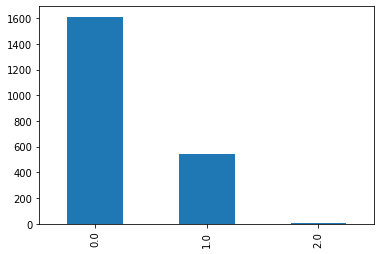

In [ ]:
#full paths to images
full_label_on_off_train_l = [savedir + suit for suit in full_label_on_off_train]
full_label_on_off_test_l = [savedir + suit for suit in full_label_on_off_test] 

pd.value_counts(y_on_off_test).plot.bar()

In [ ]:
#load train split
X_on_off, y_on_off, y_1, y_2, measurement_id_on_off, frame_on_off = read_and_process_images(full_label_on_off_train, savedir)
#Load test split
X_on_off_test, y_on_off_test, y_1, y_2, measurement_id_on_off_test, frame_on_off_test = read_and_process_images(full_label_on_off_test, savedir)

100%|██████████| 2161/2161 [23:28<00:00,  1.53it/s]


In [ ]:
X_train, X_test, y_train, y_test, y_bi_train, y_bi_test = setup_var(X_on_off, X_on_off_test, y_on_off, y_on_off_test)

Number of y classes:
 ['0.0', '2.0', '1.0']


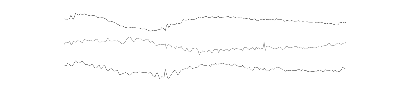

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

te = X_train[-1,:,:]
te = te.reshape(te.shape[0],te.shape[1])
cv2_imshow(te)

In [ ]:
train_model(X_train, X_test, y_train, y_test, batch_size, nrows, ncolumns, channels, y_bi_test)

2161
Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/64
270/270 [==============================] - 41s 151ms/step - loss: 0.6481 - accuracy: 0.7390 - val_loss: 0.5929 - val_accuracy: 0.7453
Epoch 2/64
270/270 [==============================] - 40s 150ms/step - loss: 0.6043 - accuracy: 0.7456 - val_loss: 0.5931 - val_accuracy: 0.7453
Epoch 3/64
270/270 [==============================] - 40s 149ms/step - loss: 0.6031 - accuracy: 0.7445 - val_loss: 0.5945 - val_accuracy: 0.7444
Epoch 4/64
270/270 [==============================] - 40s 148ms/step - loss: 0.6025 - accuracy: 0.7452 - val_loss: 0.6000 - val_accuracy: 0.7458
Epoch 5/64
270/270 [==============================] - 40s 150ms/step - loss: 0.5989 - accuracy: 0.7455 - val_loss: 0.5961 - val_accuracy: 0.7453
Epoch 6/64
270/270 [==============================] - 40s 150ms/step - loss: 0.5976 - accuracy: 0.7440 - val_loss: 0.5939 - val_accuracy: 0.7444
Epoch 7/64
270/270 [==============================] - 40s 149ms/step - loss: 0.5975 - accuracy: 0.7468 - val_loss: 0.6015 - val_ac